In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Data Cleaning
* Combine and align data into Monthly Stock File (MSF)
* Use 3-Dimensional data structure as descriptor

In [2]:
msf_raw = pd.read_csv('data/msf.csv')
indx = pd.MultiIndex.from_arrays(msf_raw.iloc[:, :2].values.T,
                                 names=['permno', 'date'])
col = ['TICKER', 'COMNAM', 'SICCD', 'RET',
       'BIDLO', 'ASKHI', 'PRC', 'VOL', 'SHROUT', 'vwretd', 'sprtrn']
msf = pd.DataFrame(data=msf_raw.loc[:, col].copy().values,
                   index=indx,
                   columns=col)

c:\python36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
finr_raw = pd.read_csv('data/finratiofirm.csv')
indx = pd.MultiIndex.from_arrays(finr_raw.iloc[:, [0, 3]].values.T,
                                 names=['permno', 'date'])
col = ['pe_exi', 'roe', 'GProf', 'PEG_trailing', 'debt_assets', 'ptb', 'divyield']
finr = pd.DataFrame(data=finr_raw.loc[:, col].copy().values,
                    index=indx,
                    columns=col)
finr = finr.reindex(pd.MultiIndex.from_product(finr.index.levels, names=['permno', 'date']))

In [4]:
fff = pd.read_csv('data/mfff.csv').set_index('dateff')
fff.index.rename('date', inplace=True)

In [5]:
indx = pd.MultiIndex.from_product(
    [msf.index.levels[0].join(finr.index.levels[0], how='inner'),
     msf.index.levels[1].join(finr.index.levels[1])],
    names=['permno', 'date'])

In [6]:
msf = msf.reindex(indx).join(finr.reindex(indx))
msf.index.set_levels(pd.to_datetime(msf.index.levels[1]), level=1, inplace=True)

In [7]:
l = slice(None)
ll = (slice(None), slice(None))
msf.loc[ll, 'PRC'] = msf.loc[ll, 'PRC'].abs()
msf.loc[ll, 'BIDLO'] = msf.loc[ll, 'BIDLO'].abs()
msf.loc[ll, 'ASKHI'] = msf.loc[ll, 'ASKHI'].abs()
msf.loc[ll, 'divyield'] = msf.loc[ll, 'divyield'].astype('str').str.replace('%', '').astype('f') / 100
msf.loc[ll, 'rf'] = np.tile(fff.rf.values, indx.levels[0].shape)

In [10]:
msf.loc[ll, 'pe'] = msf.loc[ll, 'pe_exi'].fillna(method='ffill')
msf.loc[(msf.loc[ll, 'pe'] == 0), 'pe'] = np.nan
msf.loc[ll, 'eps'] = msf.loc[ll, 'PRC'] / msf.loc[ll, 'pe']

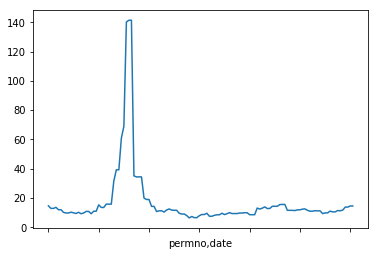

In [12]:
msf.loc[(msf.TICKER == 'JPM'), 'pe'].plot()

In [ ]:
mesh = msf.SICCD.astype('str').str.contains('[a-zA-Z]+', regex=True)
msf.loc[mesh, 'SICCD'].unique()

In [13]:
msf.loc[msf.loc[ll, 'ASKHI'].isna(), :].groupby(level=0).head(1).index.get_level_values(1).unique()

DatetimeIndex(['2013-03-28', '2017-02-28', '2012-05-31', '2008-04-30',
               '2016-03-31', '2010-02-26', '2010-06-30', '2013-04-30',
               '2007-01-31', '2007-10-31',
               ...
               '2009-10-30', '2015-08-31', '2015-10-30', '2015-04-30',
               '2013-02-28', '2014-04-30', '2015-12-31', '2010-11-30',
               '2013-05-31', '2016-08-31'],
              dtype='datetime64[ns]', name='date', length=122, freq=None)

## 2. Factor Construction
* Clean basic factor from market and fundimental data
* Calculate factor loading (exposure) as timeseries

> 1. Volatility  
  $\displaystyle log(\frac{ASKHI}{BIDLO})$

In [14]:
np.isnan(msf.loc[ll, 'ASKHI'].astype('f').values).sum()

318625

In [15]:
np.isnan(msf.loc[ll, 'BIDLO'].astype('f').values).sum()

318625

In [16]:
mesh = msf.loc[ll, 'BIDLO'].astype('str').str.contains('.', regex=False)
msf.loc[np.logical_not(mesh), 'BIDLO'].unique()

array([nan], dtype=object)

In [17]:
# msf.loc[ll, 'volatility'] = msf.loc[ll, ['ASKHI', 'BIDLO']].astype('f').groupby(level=0).apply(np.log).dot([1,-1]).values
msf.loc[ll, 'volatility'] = msf.loc[ll, ['ASKHI', 'BIDLO']].astype('f').apply(np.log).dot([1,-1]).values

> 2. Momentum:  
  $\sum_t{log(1 + RET_t) - log(1 + rf_t)}$

In [18]:
mesh = msf.loc[ll, 'RET'].astype('str').str.contains('.', regex=False)
msf.loc[~mesh, 'RET'].unique()

array([nan, 'B', 'C'], dtype=object)

In [19]:
msf.loc[ll, 'RET'] = msf.loc[ll, 'RET'].replace({'B': 'NaN', 'C': 'NaN'})

In [20]:
# msf.loc[ll, 'momentum'] = \
#     (1 + msf.loc[ll, ['RET', 'rf']].astype('f')).groupby(level=0).apply(np.log).rolling(12).sum().dot([1,-1])
msf.loc[ll, 'momentum'] = \
    np.log(1 + msf.loc[ll, ['RET', 'rf']].astype('f')).groupby(level=0).rolling(12).sum().dot([1,-1]).values

> 3. Size:  
  $log(PRC * SHROUT)$

In [21]:
np.isnan(msf.loc[ll, 'PRC'].astype('f').values).sum()

321354

In [22]:
msf.loc[ll, 'size'] = np.log((msf.loc[ll, 'PRC'] * msf.loc[(l, l), 'SHROUT']).astype('f'))

> 4. Size Nonlinearity:  
  $log^3(PRC * SHROUT)$

In [23]:
msf.loc[ll, 'size_nl'] = msf.loc[ll, 'size'] ** 3

> 5. Trading Activity:  
  $\displaystyle\frac{\sum_t{VOL}}{\frac{1}{T}\sum_t{SHROUT}}$

In [24]:
msf.loc[ll, 'trading_activity'] = (msf.loc[ll, 'VOL'].groupby(level=0).rolling(6).sum().values 
                                   / msf.loc[ll, 'SHROUT'].groupby(level=0).rolling(6).mean().values)

> 6. Growth:  
  $\displaystyle\frac{EPS_T - EPS_{T-1}}{EPS_T + EPS_{T-1}}$

In [25]:
eps_t = msf.loc[ll, 'eps'].groupby(level=0).rolling(12).sum()
eps_t0 = eps_t.values
eps_t1 = eps_t.groupby(level=0).shift(1).values
# moins = np.r_[np.array([-1] * 6), np.array([1] * 6)]
# ajouter = np.array([1] * 12)
msf.loc[ll, 'growth'] = (eps_t0 - eps_t1) / (eps_t0 + eps_t1)

> 7. Earning Yield:  
  $\displaystyle\frac{\frac{1}{T}\sum_t{EPS}}{\frac{1}{T}\sum_t{PRC}}$

In [26]:
msf.loc[ll, 'earning_yield'] = (msf.loc[ll, 'eps'].groupby(level=0).rolling(24).mean().values 
                                / msf.loc[ll, 'PRC'].groupby(level=0).rolling(24).mean().values)
# msf.loc[ll, 'earning_yield'] = msf.loc[ll, 'roe']

> 8. Value:  
  $\displaystyle\frac{1}{ptb}$

In [27]:
msf.loc[ll, 'value'] = 1 / msf.loc[ll, 'ptb'].fillna(method='ffill')

> 9. Earning Variability:  
  $\displaystyle\frac{\sigma^2(EPS)}{\mathbb{E}(EPS)}$

In [28]:
msf.loc[ll, 'earning_variability'] = (msf.loc[ll, 'eps'].groupby(level=0).rolling(12).var().values 
                                      / msf.loc[ll, 'eps'].groupby(level=0).rolling(12).mean().values)

> 10. Leverage:  
  $debt\_assets$

In [29]:
msf.loc[ll, 'leverage'] = msf.loc[ll, 'debt_assets'].fillna(method='ffill').abs()

> 11. Dividend Yield:  
  $divyield$

In [30]:
msf.loc[ll, 'divyield'] = msf.loc[ll, 'divyield'].fillna(method='ffill')

In [74]:
msf.to_hdf('data/msf.h5', 'msf')

c:\python36\lib\site-packages\pandas\core\generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['TICKER', 'COMNAM', 'SICCD', 'RET', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'SHROUT', 'vwretd', 'sprtrn', 'pe_exi', 'roe', 'GProf', 'PEG_trailing', 'debt_assets', 'ptb', 'eps']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [33]:
# pool = pd.read_csv('data/pool.csv')
# capm = pd.read_csv('data/capm.csv')
# indx_hsig = pd.MultiIndex.from_arrays(capm.iloc[:, [0, 5]].values.T,
#                                       names=['permno', 'date'])
# hsig = pd.DataFrame(data=capm.hsigma.values,
#                     index=indx_hsig,
#                     columns=['hsigma'])
# indx_expo = pd.MultiIndex.from_product(
#     [msf.index.levels[0],
#      msf.index.levels[1].astype('str').str.replace('-', '').astype('int') // 100],
#     names=['permno', 'date'])
# expo = pd.DataFrame(data=msf.loc[ll, ['RET'] + factors].values,
#                     index=indx_expo,
#                     columns=['RET'] + factors)
# ext = expo.loc[(pool.permno, l), :].join(hsig, how='inner')

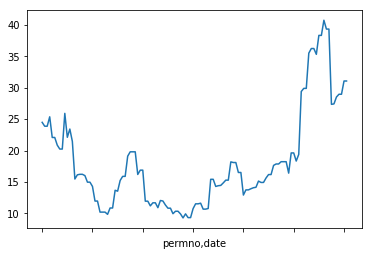

In [38]:
msf.loc[(msf.TICKER == 'MSFT'), 'pe_exi'].fillna(method='pad').plot()

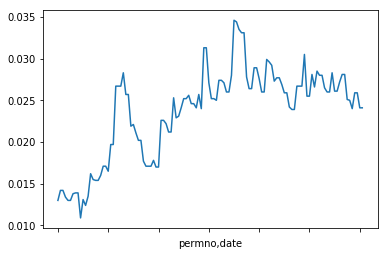

In [39]:
msf.loc[(msf.TICKER == 'MSFT'), 'divyield'].fillna(method='ffill').plot()

In [40]:
_coef = lambda x: np.linalg.inv(x[:,1:].T.dot(x[:,1:])).dot(x[:,1:].T).dot(x[:,0])

In [63]:
def trim(x):
    mu = x.mean()
    sig = x.std()
#     _x = x.copy()
    _x = x
    _x[(_x - mu).abs() > 2 * sig] = np.nan
    return _x

In [64]:
def standardize(x):
    return ((x - x.mean()) / x.std())

In [42]:
factors = ['volatility', 'momentum', 'size', 'size_nl', 'trading_activity', 'growth',
           'earning_yield', 'value', 'earning_variability', 'leverage', 'divyield']
f = pd.DataFrame([], index=msf.index.levels[1], columns=factors)
X = msf.loc[ll, factors]
e = pd.DataFrame([], index=msf.index.levels[1], columns=msf.index.levels[0])

In [76]:
_df[factors].apply(trim).apply(standardize).dropna()

,,volatility,momentum,size,size_nl,trading_activity,growth,earning_yield,value,earning_variability,leverage,divyield
permno,date,,,,,,,,,,,
10001,2008-12-31,-0.693584,1.006681,-0.817684,-0.863644,-1.011827,-0.044634,0.566136,-0.345430,0.028006,0.047168,1.665603
10025,2008-12-31,-1.235479,0.081539,-0.274470,-0.346853,-0.608576,-0.102589,0.724268,-0.829494,0.332118,1.354146,-0.751752
10026,2008-12-31,-0.320095,1.419006,0.496035,0.592519,-0.619336,0.009205,0.316470,-0.674602,0.005345,-1.248209,-0.945362
10028,2008-12-31,1.849304,-0.862286,-1.156524,-1.131367,-1.083786,0.007844,0.210062,0.032143,0.004326,-0.300844,-0.818133
10032,2008-12-31,-0.828647,0.370072,0.502289,0.601216,0.711404,0.032221,0.612378,-0.495211,0.008151,-0.095903,-0.818133
10044,2008-12-31,-1.253804,-0.726613,-0.867262,-0.905330,-0.879193,0.011136,0.422010,-0.773043,0.004898,-1.186340,2.617057
10051,2008-12-31,-1.330362,1.645291,0.322326,0.358101,0.478225,0.030841,0.170311,-0.548070,0.004774,0.491850,0.874569
10078,2008-12-31,1.224415,-1.629973,1.155541,1.612526,1.739473,-0.202720,0.112499,0.069744,0.301985,0.275309,0.874569
10092,2008-12-31,1.534615,-2.248378,-0.959066,-0.980212,-0.347864,0.071307,-0.948141,2.147214,-0.030688,-1.341012,0.874569


In [68]:
# factors = ['volatility', 'momentum', 'size', 'size_nl', 'trading_activity',
#            'earning_yield', 'leverage', 'divyield']
_msf = msf.loc[ll, (['RET'] + factors)]
_msf.loc[ll, 'RET'] = _msf.RET.groupby(level=0).shift(-1)
for date, df in _msf.groupby(level=1):
        _df = df.astype('f')
#         _df.loc[:, factors] = _df[factors].apply(standardize)
        _df.update(_df[factors].apply(trim).apply(standardize))
        _df.RET.update(trim(_df.RET))
        _df = _df.dropna()
        if not _df.empty:
            break
#             X.loc[(_df.index.get_level_values(0), date), :] = _df[factors]
            f.loc[date, :] = _coef(_df.values)
            _e = _df.RET - _df[factors].dot(f.loc[date, :])
            e.loc[date, _e.index.get_level_values(0)] = _e.values
#             break
#         if date == np.datetime64('2010-09-30'): break

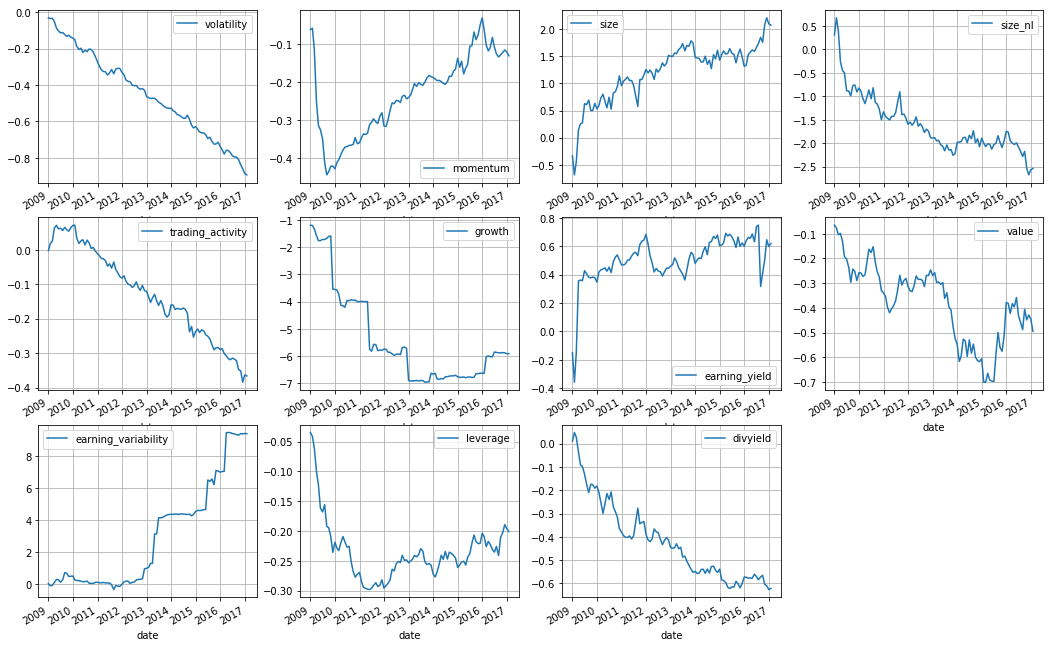

In [69]:
fig = plt.figure(figsize=(18, 12))
i = 0
for factor in factors:
    i = i + 1
    ax = fig.add_subplot(3, 4, i)
    f[factor].dropna().cumsum().plot(ax=ax, legend=True, grid=True)

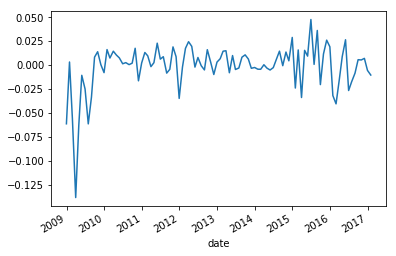

In [45]:
f.momentum.plot()

In [46]:
pd.DataFrame(f.mean() / f.std() * np.sqrt(f.dropna().shape[0]), columns=['t-statistic'])

,t-statistic
volatility,-7.055357
momentum,-0.546914
size,1.370078
size_nl,-1.575006
trading_activity,-2.676830
growth,-1.809813
earning_yield,0.721875
value,-1.174541
earning_variability,2.416199
leverage,-1.579498


In [47]:
pd.DataFrame(f.cumsum().mean() / f.cumsum().std(), columns=['sharpe_ratio'])

,sharpe_ratio
volatility,-1.939634
momentum,-2.168278
size,2.277879
size_nl,-2.556622
trading_activity,-0.989689
growth,-3.149106
earning_yield,3.010478
value,-2.437567
earning_variability,0.902617
leverage,-4.736576


## 3. Portfolio Construction  
  
  $$w = \frac{(X \Sigma X^T + e^2)^{-1}(X f - r_f)}{1^T(X \Sigma X^T + e^2)^{-1}(X f - r_f)}$$

In [48]:
w = pd.DataFrame([], index=msf.index.levels[1], columns=msf.index.levels[0])
sig = f.ewm(halflife=60, min_periods=0).cov()
err = e.ewm(halflife=12, min_periods=0).var()

In [49]:
sig = f.ewm(halflife=60, min_periods=12).cov()

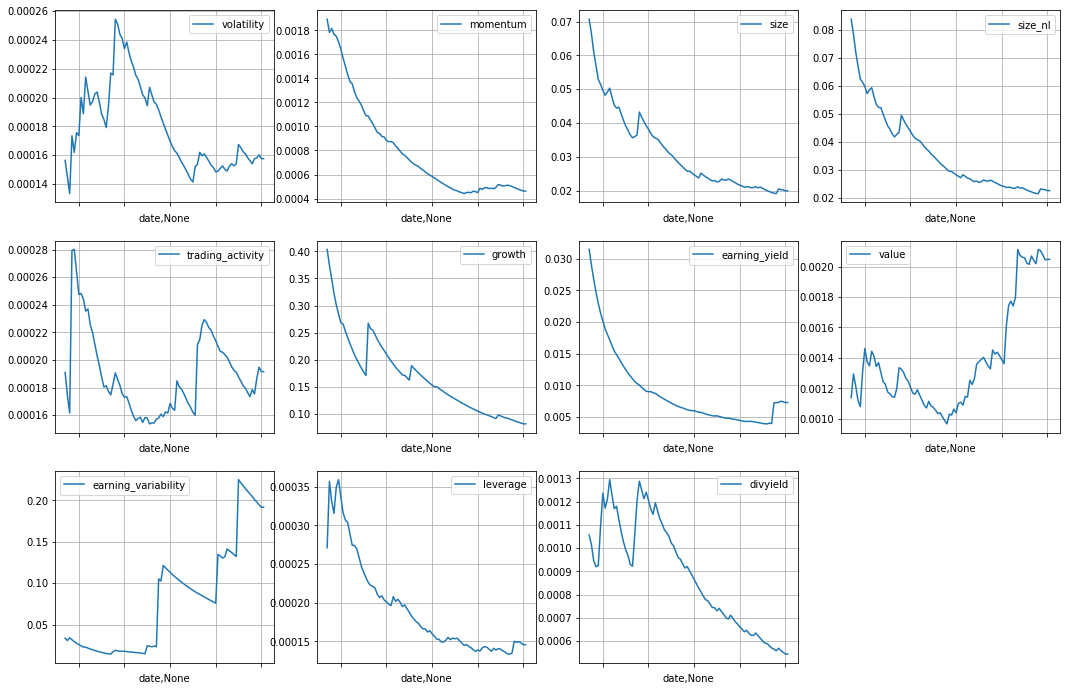

In [50]:
fig = plt.figure(figsize=(18, 12))
i = 0
for factor in factors:
    i = i + 1
    ax = fig.add_subplot(3, 4, i)
    sig.loc[(l, factor), factor].plot(ax=ax, legend=True, grid=True)

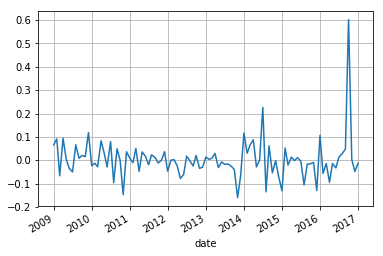

In [51]:
e.loc[:, 10001].dropna().plot(grid=True)